In [59]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [60]:
# import package
import bs4
import requests
import pandas as pd
import geopandas as gpd
import random
import math
from geopy.distance import geodesic
import sqlalchemy as db
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import matplotlib
import folium
import pandas as pd
import numpy as np
import webbrowser
from folium.plugins import HeatMap
import xlrd
import matplotlib.image as mpimg

<IPython.core.display.Javascript object>

## Part1 Data Processing

## distance calculation
Define a function to caculate distcance between two pairs of given longtitude and latitude

In [61]:
# define a function to calculate distance
def create_distance(lat1, lon1, lat2, lon2):
    dist = geodesic((lat1, lon1), (lat2, lon2)).km
    return dist

<IPython.core.display.Javascript object>

## uber_date
1. Import and go through the data, delete the data out of given range
2. Crate a 'year' column to obatin the # of datapoints in ervery year
3. Drop invalid variables and add distance to the dataframe

In [62]:
# import uber_data
uber = pd.read_csv("uber_rides_sample.csv")

<IPython.core.display.Javascript object>

In [63]:
# check
uber.head(2)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1


<IPython.core.display.Javascript object>

In [64]:
# keep data in required range
uber_select = uber[
    (uber["pickup_longitude"] >= -74.242330)
    & (uber["pickup_longitude"] <= -73.717047)
    & (uber["pickup_latitude"] >= 40.560445)
    & (uber["pickup_latitude"] <= 40.908524)
    & (uber["dropoff_longitude"] >= -74.242330)
    & (uber["dropoff_longitude"] <= -73.717047)
    & (uber["dropoff_latitude"] >= 40.560445)
    & (uber["dropoff_latitude"] <= 40.908524)
]

<IPython.core.display.Javascript object>

In [65]:
# will sample certain number of data from yellow taxi data based on this
uber_select["year"] = pd.to_datetime(uber["pickup_datetime"]).dt.year
uber_select["year"].value_counts()

<ipython-input-65-77b182171db7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_select['year'] = pd.to_datetime(uber['pickup_datetime']).dt.year


2012    31531
2011    31102
2013    30496
2009    30077
2010    29494
2014    29258
2015    13514
Name: year, dtype: int64

<IPython.core.display.Javascript object>

In [66]:
# drop invalid variables and add distance to the dataframe
uber_select.drop(
    ["Unnamed: 0", "key", "fare_amount", "passenger_count", "year"],
    axis=1,
    inplace=True,
)

<ipython-input-66-4a960f229f9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_select.drop(['Unnamed: 0','key','fare_amount','passenger_count', 'year'], axis = 1, inplace = True)


<IPython.core.display.Javascript object>

In [67]:
uber_select["distance"] = uber_select.apply(
    lambda x: create_distance(
        x["pickup_latitude"],
        x["pickup_longitude"],
        x["dropoff_latitude"],
        x["dropoff_longitude"],
    ),
    axis=1,
)

<ipython-input-67-355f9ddcbd83>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_select['distance'] = uber_select.apply(lambda x: create_distance(x['pickup_latitude'],\


<IPython.core.display.Javascript object>

In [68]:
uber_data = uber_select.reset_index()
uber_data = uber_data.drop(["index"], axis=1)

<IPython.core.display.Javascript object>

In [69]:
uber_data["pickup_datetime"] = pd.to_datetime(uber_data["pickup_datetime"])

<IPython.core.display.Javascript object>

In [70]:
uber_data.head(2)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
0,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.681111
1,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,2.454363


<IPython.core.display.Javascript object>

## yellow_taxi data
1. Improt taxi_zone.shp and convert geometry data into normal longtitue and lantitude
2. Get the url of yellow taxi and collect the data as yearly file and check the data
3. Drop invalid variables
4. Drop the data with same PULocationID and DOLocationID, merge geographical information and drop data out of given range
5. Sample the data accoring to the data amouont in uber
6. Add distance to the dataframe
7. Because data in 2010 and 2009 have different information in it, we process them seperately

In [71]:
# import taxi_zone information
taxi_zone = gpd.read_file("taxi_zones.shp")

<IPython.core.display.Javascript object>

In [72]:
# check
taxi_zone.head(2)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."


<IPython.core.display.Javascript object>

In [73]:
# change geometry information to lantitude and longtitde
taxi_zone = taxi_zone.to_crs(4326)
taxi_zone["lon"] = taxi_zone.centroid.x
taxi_zone["lat"] = taxi_zone.centroid.y

<ipython-input-73-770757aa3575>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone['lon'] = taxi_zone.centroid.x
<ipython-input-73-770757aa3575>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone['lat'] = taxi_zone.centroid.y


<IPython.core.display.Javascript object>

In [74]:
taxi_zone.head(2)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,lon,lat
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",-74.174000,40.691831
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",-73.831299,40.616745


<IPython.core.display.Javascript object>

In [75]:
#get the url of yellow taxi
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"


def get_taxi_html():
    response = requests.get(TAXI_URL)
    html = response.content
    return html


def find_taxi_parquet_links():
    html = get_taxi_html()
    soup = bs4.BeautifulSoup(html, 'html.parser')
    yellow_lst = [a['href'] for a in soup.find_all(title = 'Yellow Taxi Trip Records')]
    return yellow_lst

yellow_lst =  find_taxi_parquet_links()


<IPython.core.display.Javascript object>

In [76]:
# create the year_num list according to uber_data
year_num = [13514, 29258, 30496, 31531, 31102, 29494, 30077]

<IPython.core.display.Javascript object>

In [77]:
# define the function to get and clean data in 2011-2015
def get_and_clean_data(n):
    # generate a list to store targeted data
    file = list(range(1, 13))
    # get data using given url
    for i in range(len(file)):
        file[i] = pd.read_parquet(yellow_lst[i + 12 * n - 84])
    # drop invalid variables
    for i in range(len(file)):
        file[i].drop(
            [
                "VendorID",
                "tpep_dropoff_datetime",
                "passenger_count",
                "trip_distance",
                "RatecodeID",
                "store_and_fwd_flag",
                "payment_type",
                "fare_amount",
                "extra",
                "mta_tax",
                "tolls_amount",
                "improvement_surcharge",
                "total_amount",
                "congestion_surcharge",
                "airport_fee",
            ],
            axis=1,
            inplace=True,
        )
    # drop data when 'PULocationID' equals to 'DOLocationID'
    for i in range(len(file)):
        file[i].drop(
            file[i][file[i]["PULocationID"] == file[i]["DOLocationID"]].index,
            inplace=True,
        )
    # add logitude and latitude info for yellow taxi data
    # by using acquired longitude and latitude from taxi_zone file
    for i in range(len(file)):
        # rename variables
        file[i].rename(
            columns={
                "PULocationID": "LocationID",
                "tpep_pickup_datetime": "pickup_datetime",
            },
            inplace=True,
        )
        file[i] = pd.merge(
            file[i],
            taxi_zone[["LocationID", "lon", "lat"]],
            how="left",
            on="LocationID",
        )
        file[i].drop(["LocationID"], axis=1, inplace=True)
        file[i].rename(
            columns={
                "DOLocationID": "LocationID",
                "lon": "pickup_longitude",
                "lat": "pickup_latitude",
            },
            inplace=True,
        )
        file[i] = pd.merge(
            file[i],
            taxi_zone[["LocationID", "lon", "lat"]],
            how="left",
            on="LocationID",
        )
        file[i].drop(["LocationID"], axis=1, inplace=True)
        file[i].rename(
            columns={"lon": "dropoff_longitude", "lat": "dropoff_latitude"},
            inplace=True,
        )
    # keep data in given range
    for i in range(len(file)):
        file[i] = file[i][
            (file[i]["pickup_longitude"] >= -74.242330)
            & (file[i]["pickup_longitude"] <= -73.717047)
            & (file[i]["pickup_latitude"] >= 40.560445)
            & (file[i]["pickup_latitude"] <= 40.908524)
            & (file[i]["dropoff_longitude"] >= -74.242330)
            & (file[i]["dropoff_longitude"] <= -73.717047)
            & (file[i]["dropoff_latitude"] >= 40.560445)
            & (file[i]["dropoff_latitude"] <= 40.908524)
        ]
    file_res = pd.DataFrame()
    # sample data monthly and then put them into a file
    for i in range(len(file)):
        file_res = pd.concat(
            [file_res, file[i].sample(round(year_num[n] / 12 + 1))], axis=0
        )
    file_res = file_res.sample(year_num[n])
    file_res["distance"] = file_res.apply(
        lambda x: create_distance(
            x["pickup_latitude"],
            x["pickup_longitude"],
            x["dropoff_latitude"],
            x["dropoff_longitude"],
        ),
        axis=1,
    )

    return file_res

<IPython.core.display.Javascript object>

In [78]:
# define the function to get and clean data in 2010
def get_and_clean_data2(n):
    # generate a list to store targeted data
    file = list(range(1, 13))
    # get data using given url
    for i in range(len(file)):
        file[i] = pd.read_parquet(yellow_lst[i + 12 * n - 24])
    # drop invalid variables
    for i in range(len(file)):
        file[i].drop(
            [
                "vendor_id",
                "dropoff_datetime",
                "passenger_count",
                "trip_distance",
                "rate_code",
                "store_and_fwd_flag",
                "payment_type",
                "fare_amount",
                "surcharge",
                "mta_tax",
                "tolls_amount",
                "total_amount",
            ],
            axis=1,
            inplace=True,
        )
    # change data type to datetime
    for i in range(len(file)):
        file[i]["pickup_datetime"] = pd.to_datetime(file[i]["pickup_datetime"])
    # only keep data in given range
    for i in range(len(file)):
        file[i] = file[i][
            (file[i]["pickup_longitude"] >= -74.242330)
            & (file[i]["pickup_longitude"] <= -73.717047)
            & (file[i]["pickup_latitude"] >= 40.560445)
            & (file[i]["pickup_latitude"] <= 40.908524)
            & (file[i]["dropoff_longitude"] >= -74.242330)
            & (file[i]["dropoff_longitude"] <= -73.717047)
            & (file[i]["dropoff_latitude"] >= 40.560445)
            & (file[i]["dropoff_latitude"] <= 40.908524)
        ]
    file_res = pd.DataFrame()
    # sample data monthly and then put them into a file
    for i in range(len(file)):
        file_res = pd.concat(
            [file_res, file[i].sample(round(year_num[n + 5] / 12 + 1))], axis=0
        )
    file_res = file_res.sample(year_num[n + 5])
    file_res["distance"] = file_res.apply(
        lambda x: create_distance(
            x["pickup_latitude"],
            x["pickup_longitude"],
            x["dropoff_latitude"],
            x["dropoff_longitude"],
        ),
        axis=1,
    )

    return file_res

<IPython.core.display.Javascript object>

In [79]:
#define the function to get and clean data in 2009
def get_and_clean_data3(n):
    #generate a list to store targeted data
    file = list(range(1,13))
    #get data using given url
    for i in range(len(file)):
        file[i] = pd.read_parquet(yellow_lst[i+12*n-12])
    #drop invalid variables
    for i in range(len(file)):
        file[i].drop(['vendor_name','Trip_Dropoff_DateTime','Passenger_Count',\
                            'Trip_Distance','Rate_Code','store_and_forward',\
                            'Payment_Type','Fare_Amt','surcharge','mta_tax',\
                            'Tolls_Amt','Total_Amt'], axis = 1, inplace = True)
    #normalize variable name
    for i in range(len(file)):
        file[i].rename(columns = {'Trip_Pickup_DateTime' : 'pickup_datetime'\
                       ,'Start_Lon' : 'pickup_longitude', 'Start_Lat' : 'pickup_latitude',\
                       'End_Lon' : 'dropoff_longitude','End_Lat' : 'dropoff_latitude','Tip_Amt':'tip_amount'},\
                       inplace = True)
    #change data type to datetime
    for i in range(len(file)):
        file[i]['pickup_datetime'] = pd.to_datetime(file[i]['pickup_datetime'])
    #only keep data in given range
    for i in range(len(file)):
        file[i] = file[i][(file[i]['pickup_longitude'] >= -74.242330) \
                                & (file[i]['pickup_longitude'] <= -73.717047) \
                                & (file[i]['pickup_latitude'] >= 40.560445) \
                                & (file[i]['pickup_latitude'] <= 40.908524) \
                                &(file[i]['dropoff_longitude'] >= -74.242330) \
                                & (file[i]['dropoff_longitude'] <= -73.717047) \
                                & (file[i]['dropoff_latitude'] >= 40.560445) \
                                & (file[i]['dropoff_latitude'] <= 40.908524)]
    file_res = pd.DataFrame()
    #sample data monthly and then put them into a file
    for i in range(len(file)):
        file_res = pd.concat([file_res,file[i].sample(round(year_num[n+6]/12+1))], axis = 0)
    file_res = file_res.sample(year_num[n+6])
    file_res['distance'] = file_res.apply(lambda x: create_distance(x['pickup_latitude'],\
                                                                    x['pickup_longitude'],\
                                                                      x['dropoff_latitude'],\
                                                                   x['dropoff_longitude']), axis=1)
    
    return file_res


<IPython.core.display.Javascript object>

In [80]:
# apply above function to acquire taxi data
file2015_res = get_and_clean_data(0)

<IPython.core.display.Javascript object>

In [81]:
# apply above function to acquire taxi data
file2014_res = get_and_clean_data(1)

<IPython.core.display.Javascript object>

In [82]:
# apply above function to acquire taxi data
file2013_res = get_and_clean_data(2)

<IPython.core.display.Javascript object>

In [83]:
# apply above function to acquire taxi data
file2012_res = get_and_clean_data(3)

<IPython.core.display.Javascript object>

In [84]:
# apply above function to acquire taxi data
file2011_res = get_and_clean_data(4)

<IPython.core.display.Javascript object>

In [85]:
# apply above function to acquire taxi data
file2010_res = get_and_clean_data2(0)

<IPython.core.display.Javascript object>

In [86]:
# apply above function to acquire taxi data
file2009_res = get_and_clean_data3(0)

<IPython.core.display.Javascript object>

In [87]:
# merge yearly data into one DataFrame
yellow_taxi = pd.DataFrame()
for i in [
    file2015_res,
    file2014_res,
    file2013_res,
    file2012_res,
    file2011_res,
    file2010_res,
    file2009_res,
]:
    yellow_taxi = pd.concat([yellow_taxi, i], axis=0)

<IPython.core.display.Javascript object>

In [88]:
# reset index
yellow_taxi = yellow_taxi.reset_index()
yellow_taxi = yellow_taxi.drop(["index"], axis=1)

<IPython.core.display.Javascript object>

In [89]:
# check the data
yellow_taxi.isnull().sum()

pickup_datetime      0
tip_amount           0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
distance             0
dtype: int64

<IPython.core.display.Javascript object>

## Weather Data
1. Define functions for cleaning and processing weather data
2. Apply the functions for every year data to get yearly dataframes
3. Concatenate every year's data

In [90]:
# This delete_str() function is for processing precipitation data
# Because precipitation is in string type and T denote trace amount,
# We use an relatively small number to replace the T in order for further number calculation.
# x[:4] because there are wrongly number with "0.003s", the s we assume is a typo
def delete_str(x):
    if x == None:
        return x
    elif x == "T":
        return 0.0001
    elif type(x) == float:
        return x
    else:
        return x[:4]


# This reset_drop() function is for dataframe's column normalize
# Because we have to concatenate all the dataframes at last which need same column name and index
def reset_drop(x):
    x = x.reset_index()
    x = x.drop(["index"], axis=1)
    return x

<IPython.core.display.Javascript object>

In [91]:
# This Weather_transfer()function is used for processing yearly csv file
# into hourly weather and calculating daily weather
# Please note that calculating daily weather is specific for
# 2009-2012's data, because these data do not have daily summery(Their "SOD" row count is much smaller than 365)
# For other 2013-2015's data, we only need to fetch the "SOD" report which is for daily
# (we have test that "SOD" rows for 2013 to 2015 all have 365 entries, which we assume is sufficient)
def Weather_transfer(csv_file):
    df = pd.read_csv(csv_file)

    df = df.loc[df["REPORT_TYPE"] != "SOD  "]
    df = df.loc[df["REPORT_TYPE"] != "SOM  "]

    df_h = df[["DATE", "HourlyPrecipitation", "HourlyWindSpeed"]]

    df_h["HourlyPrecipitation"] = df_h["HourlyPrecipitation"].apply(delete_str)

    df_h["DATE_parsed"] = pd.to_datetime(df_h["DATE"], format="%Y-%m-%dT%H:%M:%S")

    # df_h['HourlyPrecipitation'] = df_h['HourlyPrecipitation'].replace(['T'], 1e-6)
    df_h["HourlyPrecipitation"] = df_h["HourlyPrecipitation"].astype(float)

    df_h["HourlyWindSpeed"] = df_h["HourlyWindSpeed"].fillna(0)
    df_h["HourlyPrecipitation"] = df_h["HourlyPrecipitation"].fillna(0)

    df_h["DATE_day"] = pd.to_datetime(df_h["DATE"], format="%Y-%m-%d").dt.date
    group = df_h.groupby("DATE_day")
    df_d = group.mean()
    df_d.rename(
        columns={
            "HourlyPrecipitation": "DailyPrecipitation",
            "HourlyWindSpeed": "DailyAverageWindSpeed",
        },
        inplace=True,
    )
    df_d["DailyPrecipitation"] = df_d["DailyPrecipitation"].fillna(0)
    # df_h['HourlyPrecipitation'] = df_h['HourlyPrecipitation'].fillna(0)

    df_h["DATE"] = df_h["DATE_parsed"]
    df_h.drop(["DATE_parsed", "DATE_day"], axis=1, inplace=True)

    df_d.reset_index(inplace=True)

    list_df = [df_h, df_d]
    return list_df

<IPython.core.display.Javascript object>

In [92]:
# This get_daily() function is specific for year from 2013 to 2015
# As their SOD daily summery is compelete and reliable
def get_daily(csv_file):
    weather_df = pd.read_csv(csv_file)
    df_daily = weather_df.loc[weather_df["REPORT_TYPE"] == "SOD  "][
        ["DATE", "DailyPrecipitation", "DailyAverageWindSpeed"]
    ]
    df_daily["DailyPrecipitation"] = df_daily["DailyPrecipitation"].apply(delete_str)
    df_daily["DailyPrecipitation"] = df_daily["DailyPrecipitation"].astype(float)
    df_daily["DailyAverageWindSpeed"] = df_daily["DailyAverageWindSpeed"].astype(float)

    df_daily["DailyAverageWindSpeed"] = df_daily["DailyAverageWindSpeed"].fillna(0)

    df_daily["Date"] = pd.to_datetime(
        df_daily["DATE"], format="%Y-%m-%dT%H:%M:%S"
    ).dt.date
    df_daily["DATE"] = df_daily["Date"]
    df_daily = df_daily.drop(["Date"], axis=1)
    df_daily.rename({"DATE": "DATE_day"}, axis=1, inplace=True)
    # df_daily.set_index(['DATE_day'], inplace = True)
    df_daily.reindex(
        columns=["DATE_day", "DailyPrecipitation", "DailyAverageWindSpeed"]
    )

    df_daily.reset_index(inplace=True)
    df_daily = df_daily.drop(["index"], axis=1)
    return df_daily

<IPython.core.display.Javascript object>

In [93]:
# This get_sun function is for getting the sunrise and sunset time for everyday of 2009 to 2015
def get_sun(csv_file):
    weather_df_09 = pd.read_csv(csv_file)
    df = weather_df_09.loc[weather_df_09["REPORT_TYPE"] == "SOD  "][
        ["DATE", "Sunrise", "Sunset"]
    ]
    df["Sunrise"] = "0" + df["Sunrise"].astype(int).astype(str)
    df["Sunset"] = df["Sunset"].astype(int).astype(str)
    df["DATE_day"] = pd.to_datetime(weather_df_09["DATE"], format="%Y-%m-%d").dt.date
    df["DATE_Sunrise_str"] = (
        df["DATE_day"].astype(str) + "0" + df["Sunrise"].astype(int).astype(str)
    )
    df["DATE_Sunset_str"] = df["DATE_day"].astype(str) + df["Sunset"].astype(
        int
    ).astype(str)
    df["Sunrise_Time"] = pd.to_datetime(df["DATE_Sunrise_str"], format="%Y-%m-%d%H%M")
    df["Sunset_Time"] = pd.to_datetime(df["DATE_Sunset_str"], format="%Y-%m-%d%H%M")
    df_sun = df[["Sunrise_Time", "Sunset_Time"]]

    df_sun.reset_index(inplace=True)
    df_sun = df_sun.drop(["index"], axis=1)
    return df_sun

<IPython.core.display.Javascript object>

In [94]:
# Here we apply the functions to get a list of yearly generated dataframes
# Finally we stack the df one on another to get 2012-2015 data
# Note that Here is for hourly and daily weather
ls_09 = Weather_transfer("2009_weather.csv")
ls_10 = Weather_transfer("2010_weather.csv")
ls_11 = Weather_transfer("2011_weather.csv")
ls_12 = Weather_transfer("2012_weather.csv")
ls_13 = [Weather_transfer("2013_weather.csv")[0], get_daily("2013_weather.csv")]
ls_14 = [Weather_transfer("2014_weather.csv")[0], get_daily("2014_weather.csv")]
ls_15 = [Weather_transfer("2015_weather.csv")[0], get_daily("2015_weather.csv")]
name_lst = [ls_09, ls_10, ls_11, ls_12, ls_13, ls_14, ls_15]
weather_hour = pd.DataFrame()
weather_day = pd.DataFrame()
for i in range(7):
    weather_hour = pd.concat([weather_hour, name_lst[i][0]], axis=0)
    weather_day = pd.concat([weather_day, name_lst[i][1]], axis=0)

<ipython-input-91-f775f1c5a688>:8: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
<ipython-input-91-f775f1c5a688>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['HourlyPrecipitation'] = df_h['HourlyPrecipitation'].apply(delete_str)
<ipython-input-91-f775f1c5a688>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['DATE_parsed'] = pd.to_datetime(df_h['DATE'], format = "%Y-%m-%dT%H:%M:%S")
<ipython-input-91-f775f1

<ipython-input-91-f775f1c5a688>:8: DtypeWarning: Columns (17,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
<ipython-input-91-f775f1c5a688>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['HourlyPrecipitation'] = df_h['HourlyPrecipitation'].apply(delete_str)
<ipython-input-91-f775f1c5a688>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['DATE_parsed'] = pd.to_datetime(df_h['DATE'], format = "%Y-%m-%dT%H:%M:%S")
<ipython-input-91-f775f

<IPython.core.display.Javascript object>

In [95]:
# Same process as before but different function
# Note that Here is only for daily sunset and sunrise
sun_09 = get_sun("2009_weather.csv")
sun_10 = get_sun("2010_weather.csv")
sun_11 = get_sun("2011_weather.csv")
sun_12 = get_sun("2012_weather.csv")
sun_13 = get_sun("2013_weather.csv")
sun_14 = get_sun("2014_weather.csv")
sun_15 = get_sun("2015_weather.csv")
sun_lst = [sun_09, sun_10, sun_11, sun_12, sun_13, sun_14, sun_15]
sun_time = pd.DataFrame()
for i in range(7):
    sun_time = pd.concat([sun_time, sun_lst[i]], axis=0)

<ipython-input-93-deade00a99a5>:3: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df_09 = pd.read_csv(csv_file)
<ipython-input-93-deade00a99a5>:3: DtypeWarning: Columns (8,9,10,17) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df_09 = pd.read_csv(csv_file)
<ipython-input-93-deade00a99a5>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df_09 = pd.read_csv(csv_file)
<ipython-input-93-deade00a99a5>:3: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df_09 = pd.read_csv(csv_file)
<ipython-input-93-deade00a99a5>:3: DtypeWarning: Columns (17,78) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df_09 = pd.read_csv(csv_file)
<ipython-input-93-deade00a99a5>:3: DtypeWarning: Columns (8,9,17,18,78) have mixed types. 

<IPython.core.display.Javascript object>

In [96]:
weather_hour = reset_drop(weather_hour)
weather_day = reset_drop(weather_day)
sun_time = reset_drop(sun_time)

<IPython.core.display.Javascript object>

## Part2 Create SQL database
create a database conytaining 5 tables (4 required table and 1 table for sunset and sunrise data)

In [97]:
DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"
engine = db.create_engine(DATABASE_URL)

<IPython.core.display.Javascript object>

In [98]:
COMMAND = [
    """
DROP TABLE IF EXISTS taxi_trips
""",
    """
DROP TABLE IF EXISTS uber_trips""",
    """
DROP TABLE IF EXISTS hourly_weather""",
    """
DROP TABLE IF EXISTS daily_weater
""",
]
for i in COMMAND:
    engine.execute(i)

<IPython.core.display.Javascript object>

In [99]:
# Create our 5 tables
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NO EXITS hourly_weather
(
    id INTERGER PRIMARY KEY,
    DATE DATE,
    HourlyPrecipitation FLOAT,
    HourlyWindSpeed FLOAT
)
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NO EXITS daily_weather
(
    id INTERGER PRIMARY KEY,
    DATE_day DATE,
    DailyPrecipitation FLOAT,
    DailyAverageWindSpeed FLOAT,
)
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NO EXITS taxi_trips
(
    id INTERGER PRIMARY KEY,
    pickup_datetime DATETIME,
    tip_amount FLOAT,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
)
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NO EXITS uber_trips
(
    id INTERGER PRIMARY KEY,
    pickup_datetime FLOAT,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
)
"""

SUN_TIME_SCHEMA = """
CREATE TABLE IF NO EXITS sun_time
(
    id INTERGER PRIMARY KEY,
    Sunrise_Time DATETIME,
    Sunset_Time DATETIME
)
"""

<IPython.core.display.Javascript object>

In [100]:
# Create the required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(SUN_TIME_SCHEMA)

<IPython.core.display.Javascript object>

In [101]:
# Create the tables with the schema files
with engine.connect() as connection:
    pass

<IPython.core.display.Javascript object>

## Add data into database
add cleaned data to the table we create above

In [102]:
def write_dataframes_to_table(table_to_df_dict):
    add = list(table_to_df_dict.items())
    for i in range(len(add)):
        add[i][1].to_sql(add[i][0], engine)
        print("added", add[i][0])

<IPython.core.display.Javascript object>

In [103]:
map_table_name_to_dataframe = {
    "taxi_trips": yellow_taxi,
    "uber_trips": uber_data,
    "hourly_weather": weather_hour,
    "daily_weather": weather_day,
    "sun_time": sun_time,
}

<IPython.core.display.Javascript object>

In [104]:
write_dataframes_to_table(map_table_name_to_dataframe)

added taxi_trips
added uber_trips
added hourly_weather
added daily_weather
added sun_time


<IPython.core.display.Javascript object>

In [110]:
# check the data
pd.read_sql("daily_weather", engine).head()

,index,DATE_day,DailyPrecipitation,DailyAverageWindSpeed
0,0,2009-01-01,0.000000,11.041667
1,1,2009-01-02,0.000029,6.806452
2,2,2009-01-03,0.000004,9.875000
3,3,2009-01-04,0.000000,7.370370
4,4,2009-01-05,0.000004,6.925926


<IPython.core.display.Javascript object>

In [109]:
pd.read_sql("taxi_trips", engine).head()

,index,pickup_datetime,tip_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
0,0,2015-07-24 13:15:37,1.75,-74.016079,40.712038,-74.007880,40.717772,0.941031
1,1,2015-10-26 08:09:29,1.76,-73.989844,40.762252,-73.972356,40.756687,1.600848
2,2,2015-03-09 20:51:37,2.26,-73.988786,40.753512,-73.987645,40.775965,2.495198
3,3,2015-03-21 15:27:02,4.89,-73.940772,40.818257,-73.965553,40.782478,4.490106
4,4,2015-10-02 09:54:44,2.95,-73.992437,40.748497,-73.997380,40.728340,2.276986


<IPython.core.display.Javascript object>

## Part3 Understanding the Data

In [151]:
def write_query_to_file(query, outfile):
    QUERY_FILE = f"{outfile}.sql"
    with open(QUERY_FILE, "w") as f:
        f.write(query)

<IPython.core.display.Javascript object>

### Q1
For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.

In [107]:
QUERY_1 = """
SELECT COUNT(*) AS trips, strftime('%H', pickup_datetime) AS hour
FROM taxi_trips
WHERE pickup_datetime <'2015-07-01 00:00:00'
GROUP BY hour
ORDER BY trips
"""
result1 = engine.execute(QUERY_1).fetchall()

<IPython.core.display.Javascript object>

In [153]:
write_query_to_file(QUERY_1, "most_popular_hour_taxi")

<IPython.core.display.Javascript object>

### Q2
For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.

In [111]:
QUERY_2 = """
SELECT COUNT(*) AS trips, strftime('%w', pickup_datetime) AS WeekNumber
FROM uber_trips
GROUP BY WeekNumber
ORDER BY trips
"""
result2 = engine.execute(QUERY_2).fetchall()

<IPython.core.display.Javascript object>

In [154]:
write_query_to_file(QUERY_2, "most_popular_dayofweek_uber")

<IPython.core.display.Javascript object>

### Q3
What is the 95% percentile of distance traveled for all hired trips during July 2013?

In [112]:
QUERY_3 = """
WITH allrides AS(
SELECT distance FROM taxi_trips
WHERE pickup_datetime BETWEEN '2013-07-01 00:00:00' AND '2013-07-31 23:59:59'
UNION ALL
SELECT distance FROM uber_trips
WHERE pickup_datetime BETWEEN '2013-07-01 00:00:00' AND '2013-07-31 23:59:59')

SELECT distance
FROM allrides

ORDER BY distance ASC

LIMIT 1
OFFSET (
SELECT COUNT(*)
FROM allrides) * (95) / 100 - 1
"""
result3 = engine.execute(QUERY_3).fetchall()

<IPython.core.display.Javascript object>

In [155]:
write_query_to_file(QUERY_3, "percentile95_distance_allrides")

<IPython.core.display.Javascript object>

### Q4
What were the top 10 days with the highest number of hired rides for 2009, and what
was the average distance for each day?

In [113]:
QUERY_4 = """
WITH allrides AS(
SELECT pickup_datetime, distance FROM taxi_trips
WHERE pickup_datetime between '2009-01-01 00:00:00' AND '2009-12-31 23:59:59'
UNION ALL
SELECT pickup_datetime, distance FROM uber_trips
WHERE pickup_datetime between '2009-01-01 00:00:00' AND '2009-12-31 23:59:59')

SELECT date(pickup_datetime) AS day, AVG(distance) AS mean_dist, COUNT(*) AS trips
FROM allrides

GROUP BY day
ORDER BY trips DESC
LIMIT 10
"""
result4 = engine.execute(QUERY_4).fetchall()

<IPython.core.display.Javascript object>

In [156]:
write_query_to_file(QUERY_4, "top_10_rides_2009")

<IPython.core.display.Javascript object>

### Q5
Which 10 days in 2014 were the windiest on average, and how many hired trips were
made on those days?

In [114]:
QUERY_5 = """
WITH all_rides AS (
SELECT pickup_datetime
FROM taxi_trips
UNION ALL
SELECT pickup_datetime
FROM uber_trips
)
SELECT date(pickup_datetime) AS date, COUNT(*)
FROM all_rides
GROUP BY date
HAVING date IN (SELECT date(DATE)
                FROM daily_weather
                WHERE DATE BETWEEN '2014-01-01' AND '2014-12-31'
                ORDER BY DailyAverageWindSpeed DESC
                LIMIT 10)
LIMIT 10;
"""
result5 = engine.execute(QUERY_5).fetchall()

<IPython.core.display.Javascript object>

In [157]:
write_query_to_file(QUERY_5, "top_10_windest_2014")

<IPython.core.display.Javascript object>

### Q6
During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the
week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

In [115]:
QUERY_6 = """
WITH all_rides AS (
SELECT strftime('%m/%d/%Y %H', pickup_datetime) as ride_to_hour
FROM taxi_trips
WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-11-07'
UNION ALL
SELECT strftime('%m/%d/%Y %H', pickup_datetime) as ride_to_hour
FROM uber_trips
WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-11-07')

SELECT strftime('%m/%d/%Y %H', DATE) AS weather_to_hour,
COALESCE(COUNT(all_rides.ride_to_hour), 0) AS rides_count,
HourlyPrecipitation,
HourlyWindSpeed

FROM hourly_weather
LEFT OUTER JOIN all_rides
ON weather_to_hour = ride_to_hour
WHERE hourly_weather.DATE BETWEEN '2012-10-22' AND '2012-11-07'
GROUP BY weather_to_hour


"""
result6 = engine.execute(QUERY_6).fetchall()

<IPython.core.display.Javascript object>

In [158]:
write_query_to_file(QUERY_6, "HS_hourly_combine")

<IPython.core.display.Javascript object>

## Part4 

### P1
Create an appropriate visualization for the first query/question in part 3.

In [116]:
P1 = pd.DataFrame(result1)

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='hour'>

<Figure size 500x500 with 0 Axes>

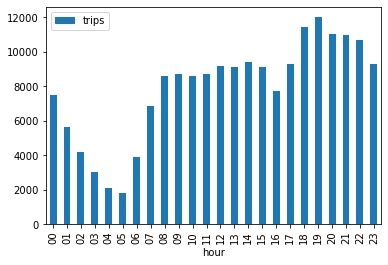

<IPython.core.display.Javascript object>

In [117]:
plt.figure(figsize=(5, 5), dpi=100)
P1.groupby(["hour"]).mean().plot.bar()

### P2
Create a visualization that shows the average distance traveled per month (regardless of
year - so group by each month) for both taxis and Ubers combined. Include the 90%
confidence interval around the mean in the visualization.

In [118]:
QUERY_p2 = """
SELECT strftime('%m', pickup_datetime) AS month, distance FROM taxi_trips
UNION ALL
SELECT strftime('%m', pickup_datetime) AS month, distance FROM uber_trips
"""
result_p2 = engine.execute(QUERY_p2).fetchall()

<IPython.core.display.Javascript object>

In [119]:
P2 = pd.DataFrame(result_p2)
P2["month"] = P2["month"].astype("int64")

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='month', ylabel='distance'>

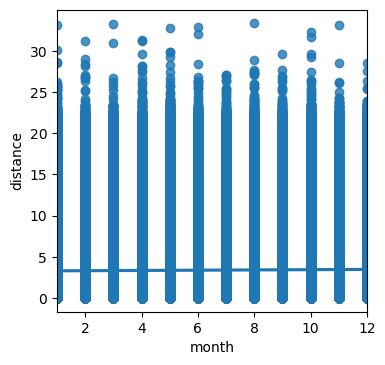

<IPython.core.display.Javascript object>

In [120]:
plt.figure(figsize=(4, 4), dpi=100)
sns.regplot(x=P2["month"], y=P2["distance"], ci=90)

### P3
Define three lat/long coordinate boxes around the three major New York airports: LGA,
JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares
what day of the week was most popular for drop offs for each airport.

* *Bar chart for EWR Airport*

In [121]:
# EWR(-74.200974,40.671395)(-74.148617,40.709662)
QUERY_p3_EWR = """
WITH allrides AS(
SELECT pickup_datetime, dropoff_longitude, dropoff_latitude FROM taxi_trips
WHERE dropoff_longitude <=  '-74.148617'
AND dropoff_longitude >= '-74.200974'
AND dropoff_latitude<= '40.709662'
AND dropoff_latitude>= '40.671395'
UNION ALL
SELECT pickup_datetime, dropoff_longitude, dropoff_latitude FROM uber_trips
WHERE dropoff_longitude <= '-74.148617'
AND dropoff_longitude >= '-74.200974'
AND dropoff_latitude<= '40.709662'
AND dropoff_latitude>= '40.671395')

SELECT COUNT(*) AS trips, strftime('%w', pickup_datetime) AS WeekNumber
FROM allrides
GROUP BY WeekNumber

"""
result_p3_EWR = engine.execute(QUERY_p3_EWR).fetchall()

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='WeekNumber', ylabel='trips'>

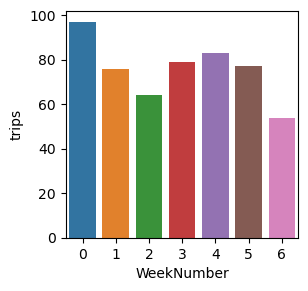

<IPython.core.display.Javascript object>

In [122]:
EWR = pd.DataFrame(result_p3_EWR)
plt.figure(figsize=(3, 3), dpi=100)
sns.barplot(data=EWR, x="WeekNumber", y="trips")

* *Bar chart for LGA Airport*

In [123]:
# LGA(-73.886919,40.765136)(-73.860655,40.780281)
QUERY_p3_LGA = """
WITH allrides AS(
SELECT pickup_datetime, dropoff_longitude, dropoff_latitude FROM taxi_trips
WHERE dropoff_longitude <=  '-73.860655'
AND dropoff_longitude >= '-73.886919'
AND dropoff_latitude<= '40.780281'
AND dropoff_latitude>= '40.765136'
UNION ALL
SELECT pickup_datetime, dropoff_longitude, dropoff_latitude FROM uber_trips
WHERE dropoff_longitude <= '-73.860655'
AND dropoff_longitude >= '-73.886919'
AND dropoff_latitude<= '40.780281'
AND dropoff_latitude>= '40.765136')

SELECT COUNT(*) AS trips, strftime('%w', pickup_datetime) AS WeekNumber
FROM allrides
GROUP BY WeekNumber

"""
result_p3_LGA = engine.execute(QUERY_p3_LGA).fetchall()

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='WeekNumber', ylabel='trips'>

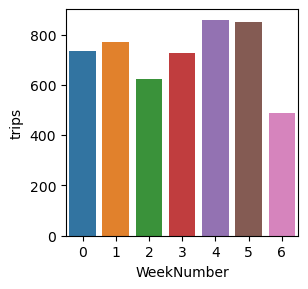

<IPython.core.display.Javascript object>

In [124]:
LGA = pd.DataFrame(result_p3_LGA)
plt.figure(figsize=(3, 3), dpi=100)
sns.barplot(data=LGA, x="WeekNumber", y="trips")

* *Bar chart for JFK Airport*

In [125]:
# JFK(-73.816109,40.676342)(-73.768387,40.620728)
QUERY_p3_JFK = """
WITH allrides AS(
SELECT pickup_datetime, dropoff_longitude, dropoff_latitude FROM taxi_trips
WHERE dropoff_longitude <=  '-73.768387'
AND dropoff_longitude >= '-73.816109'
AND dropoff_latitude<= '40.676342'
AND dropoff_latitude>= '40.620728'
UNION ALL
SELECT pickup_datetime, dropoff_longitude, dropoff_latitude FROM uber_trips
WHERE dropoff_longitude <= '-73.768387'
AND dropoff_longitude >= '-73.816109'
AND dropoff_latitude<= '40.676342'
AND dropoff_latitude>= '40.620728')

SELECT COUNT(*) AS trips, strftime('%w', pickup_datetime) AS WeekNumber
FROM allrides
GROUP BY WeekNumber

"""
result_p3_JFK = engine.execute(QUERY_p3_JFK).fetchall()

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='WeekNumber', ylabel='trips'>

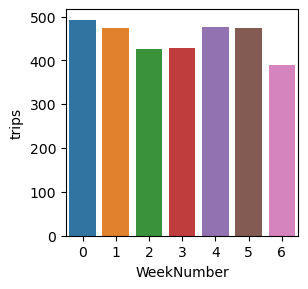

<IPython.core.display.Javascript object>

In [126]:
JFK = pd.DataFrame(result_p3_JFK)
plt.figure(figsize=(3, 3), dpi=100)
sns.barplot(data=JFK, x="WeekNumber", y="trips")

### P4
Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.

In [127]:
QUERY_p4 = """

SELECT pickup_latitude, pickup_longitude FROM taxi_trips
UNION ALL
SELECT pickup_latitude, pickup_longitude FROM uber_trips

"""
result_p4 = engine.execute(QUERY_p4).fetchall()

<IPython.core.display.Javascript object>

In [128]:
P4 = pd.DataFrame(result_p4)
# obtain longitude and latitude and save them
LAT_new = P4["pickup_latitude"]  # latitude
LNG_new = P4["pickup_longitude"]  # longitude
LOC = []
# use zip to construct tuple
for lng, lat in zip(list(LNG_new), list(LAT_new)):
    LOC.append([lat, lng])

Center = [
    np.mean(np.array(LAT_new, dtype="float32")),
    np.mean(np.array(LNG_new, dtype="float32")),
]
m = folium.Map(location=Center, zoom_start=8.5)
HeatMap(LOC).add_to(m)

# save as html file
name = "heatmap.html"
m.save(name)

webbrowser.open(name, new=2)

True

<IPython.core.display.Javascript object>

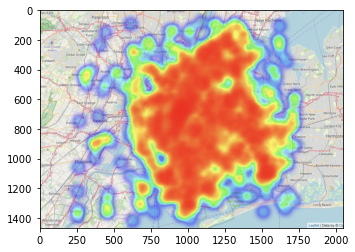

<IPython.core.display.Javascript object>

In [130]:
# Read Images
img = mpimg.imread("heatmap.png")
# Output Images
plt.imshow(img)

### P5
Create a scatter plot that compares tip amount versus distance.

In [131]:
QUERY_p5 = """

SELECT tip_amount, distance
FROM taxi_trips
WHERE tip_amount <= 20

"""
result_p5 = engine.execute(QUERY_p5).fetchall()

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='distance', ylabel='tip_amount'>

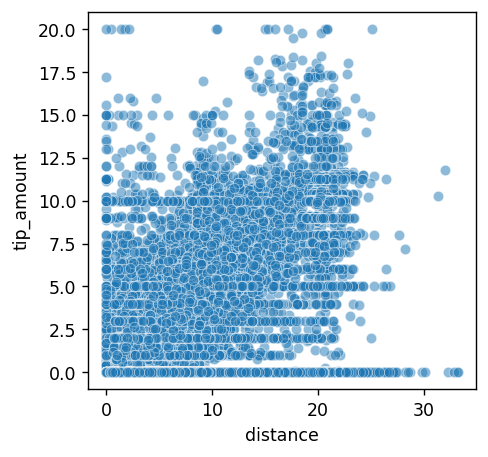

<IPython.core.display.Javascript object>

In [138]:
P5 = pd.DataFrame(result_p5)
plt.figure(figsize=(4, 4), dpi=125)
sns.scatterplot(data=P5, x="distance", y="tip_amount", alpha=0.5)

### P6
Create another scatter plot that compares tip amount versus precipitation amount.

In [135]:
QUERY_p6_1 = """

SELECT pickup_datetime, tip_amount
FROM taxi_trips
WHERE tip_amount <= 30

"""

QUERY_p6_2 = """

SELECT DATE_day, DailyPrecipitation
FROM daily_weather

"""

result_p6_1 = engine.execute(QUERY_p6_1).fetchall()
result_p6_2 = engine.execute(QUERY_p6_2).fetchall()

<IPython.core.display.Javascript object>

In [136]:
P6_1 = pd.DataFrame(result_p6_1)
P6_2 = pd.DataFrame(result_p6_2)
P6_1["day"] = pd.to_datetime(P6_1["pickup_datetime"]).dt.day
P6_2["day"] = pd.to_datetime(P6_2["DATE_day"]).dt.day

<IPython.core.display.Javascript object>

In [137]:
P6 = pd.merge(P6_1, P6_2, how="left", on="day")

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='DailyPrecipitation', ylabel='tip_amount'>

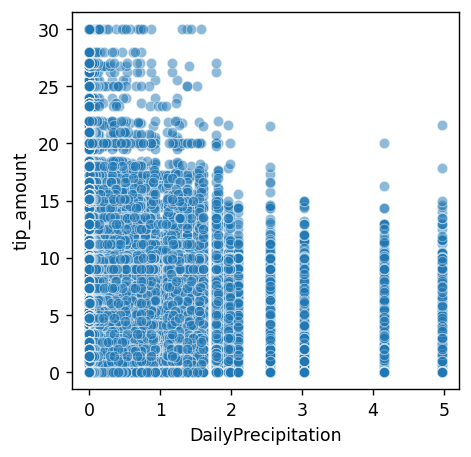

<IPython.core.display.Javascript object>

In [139]:
plt.figure(figsize=(4, 4), dpi=125)
sns.scatterplot(data=P6, x="DailyPrecipitation", y="tip_amount", alpha=0.5)

### Extra Credit
#### Sun_set
For what hour of the sunset time was the most popular to take a taxi in 2014? 

In [140]:
QUERY_taxi = """
SELECT COUNT(*) AS trips, strftime('%H', pickup_datetime) AS hour
FROM taxi_trips
WHERE pickup_datetime Between '2014-01-01 00:00:00' and '2015-01-01 00:00:00'
GROUP BY hour
"""
result_taxi = engine.execute(QUERY_taxi).fetchall()

QUERY_sun = """

SELECT strftime('%H', Sunset_Time) AS hour
FROM sun_time

"""

result_taxi = engine.execute(QUERY_taxi).fetchall()
result_sun = engine.execute(QUERY_sun).fetchall()

<IPython.core.display.Javascript object>

In [141]:
P_taxi = pd.DataFrame(result_taxi)
P_sun = pd.DataFrame(result_sun)
P_sun = pd.merge(P_sun, P_taxi, how="left", on="hour")

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='hour'>

<Figure size 500x500 with 0 Axes>

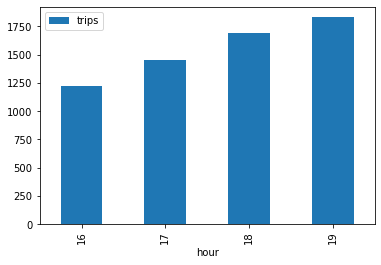

<IPython.core.display.Javascript object>

In [142]:
plt.figure(figsize=(5, 5), dpi=100)
P_sun.groupby(["hour"]).mean().plot.bar()